
# Galaxy distribution

This example simulates a matter-only light cone up to redshift 1 and samples
galaxies from a uniform distribution in redshift.  The results are shown in a
pseudo-3D plot.


## Setup
Set up a galaxy positions-only GLASS simulation.  It matches the definition
from the :doc:`/basic/shells` example, so that the pre-computed angular matter
power spectra can be used here.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# use the CAMB cosmology that generated the matter power spectra
import camb
from cosmology import Cosmology

# GLASS imports: matter, random fields, random points, galaxies
import glass.shells
import glass.fields
import glass.points
import glass.galaxies


# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# basic parameters of the simulation
nside = lmax = 128

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2,
                       NonLinear=camb.model.NonLinear_both)

# get the cosmology from CAMB
cosmo = Cosmology.from_camb(pars)

# shells of 200 Mpc in comoving distance spacing
zb = glass.shells.distance_grid(cosmo, 0., 1., dx=200.)

# uniform matter weight function
ws = glass.shells.tophat_windows(zb)

# load the angular matter power spectra previously computed with CAMB
cls = np.load('cls.npy')

## Matter



In [2]:
# compute Gaussian cls for lognormal fields for 3 correlated shells
gls = glass.fields.lognormal_gls(cls, nside=nside, lmax=lmax, ncorr=3)

# generator for lognormal matter fields
matter = glass.fields.generate_lognormal(gls, nside, ncorr=3)

## Galaxies



In [3]:
# constant galaxy density distribution
z = np.linspace(0., 1., 100)
dndz = np.full_like(z, 0.01)

## Simulation
The goal of this example is to make a 3D cube of the sampled galaxy numbers.
A redshift cube is initialised with zero counts, and the simulation is run.
For every shell in the light cone, the galaxies are counted in the cube.



In [4]:
# make a cube for galaxy number in redshift
zcub = np.linspace(-zb[-1], zb[-1], 21)
cube = np.zeros((zcub.size-1,)*3)

# simulate and add galaxies in each matter shell to cube
for i, delta_i in enumerate(matter):

    # restrict galaxy distribution to this shell
    z_i, dndz_i = glass.shells.restrict(z, dndz, ws[i])

    # compute galaxy density in this shell
    ngal = np.trapz(dndz_i, z_i)

    # simulate positions from matter density
    for gal_lon, gal_lat, gal_count in glass.points.positions_from_delta(ngal, delta_i):

        # sample redshifts uniformly in shell
        gal_z = glass.galaxies.redshifts_from_nz(gal_count, ws[i].za, ws[i].wa)

        # add counts to cube
        z1 = gal_z*np.cos(np.deg2rad(gal_lon))*np.cos(np.deg2rad(gal_lat))
        z2 = gal_z*np.sin(np.deg2rad(gal_lon))*np.cos(np.deg2rad(gal_lat))
        z3 = gal_z*np.sin(np.deg2rad(gal_lat))
        (i, j, k), c = np.unique(np.searchsorted(zcub[1:], [z1, z2, z3]), axis=1, return_counts=True)
        cube[i, j, k] += c

## Visualisation
Lastly, make a pseudo-3D plot by stacking a number of density slices on top of
each other.



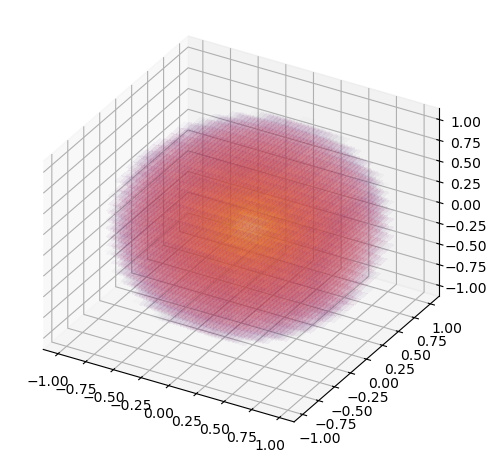

In [5]:
# positions of grid cells of the cube
z = (zcub[:-1] + zcub[1:])/2
z1, z2, z3 = np.meshgrid(z, z, z)

# plot the galaxy distribution in pseudo-3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', proj_type='ortho')
norm = LogNorm(vmin=np.min(cube[cube > 0]), vmax=np.max(cube), clip=True)
for i in range(len(zcub)-1):
    v = norm(cube[..., i])
    c = plt.cm.inferno(v)
    c[..., -1] = 0.2*v
    ax.plot_surface(z1[..., i], z2[..., i], z3[..., i], rstride=1, cstride=1,
                    facecolors=c, linewidth=0, shade=False, antialiased=False)
fig.tight_layout()
plt.show()